In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pytz
from dateutil import tz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [2]:
[region, zipcode] = ['CAISO','92562']
#[region, zipcode] = ['PJM','08641']
datasource = 'L'

In [3]:
#Load data first
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
dataDir = mainDir + '/data/load/' + region +'/'
loaddata = pd.read_csv(dataDir +'/load_with_full_forecast_integration.csv')
loaddata['tsLocal'] = loaddata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [4]:
loaddata.loc[loaddata['load'].isnull(),['tsLocal','load']]

,tsLocal,load


In [5]:
#for load, make a reference to previous week and previous year 
#Day ahead prediction
loaddata['load-predict-DayAhead-ref'] = 0.5*(loaddata['load-1w']+loaddata['load-1y']) 
#Smootening
loaddata['load-predict-DayAhead-ref+1'] = float('NaN')
loaddata['load-predict-DayAhead-ref-1'] = float('NaN')
loaddata.loc[1:loaddata.shape[0],'load-predict-DayAhead-ref-1'] = list(loaddata['load-predict-DayAhead-ref'].iloc[0:(loaddata.shape[0]-1)])
loaddata.loc[0:(loaddata.shape[0]-2),'load-predict-DayAhead-ref+1'] = list(loaddata['load-predict-DayAhead-ref'].iloc[1:(loaddata.shape[0])])
loaddata['load-predict-DayAhead'] = \
    (loaddata['load-predict-DayAhead-ref']+loaddata['load-predict-DayAhead-ref-1']+loaddata['load-predict-DayAhead-ref+1'])/3.0


In [6]:
#PV data
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
PVdata = pd.read_csv(dataDir +'/data_with_full_forecast_integration.csv')
PVdata['tsLocal'] = PVdata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

## Data integration

In [7]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15) #Here we are only interested in an hour operation
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,loaddata,on=['tsLocal'], how = 'left') 

In [8]:
index = [(d.columns=='load').nonzero()[0][0],(d.columns=='load_ref').nonzero()[0][0], (d.columns=='load-predict-DayAhead').nonzero()[0][0]]
#Interpolate load values to 15 mins
for j in index:
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
            #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

In [9]:
d = pd.merge(d,PVdata,on=['tsLocal'], how = 'left') 

In [10]:
#Check column names needed and make it solid
Data = d
Data_full = Data

In [11]:
#Define scale of PV deployment: maximum load of the year
maxload = np.max(Data_full['load'])
print maxload

43479.84


In [12]:
d_imm = Data_full
d_imm['load-1'] = float('NaN')
d_imm.loc[1:Data.shape[0],'load-1'] = list(d_imm['load'].iloc[0:(d_imm.shape[0]-1)])
maxramprate = np.max(np.absolute(d_imm['load']- d_imm['load-1'])*4)
print maxramprate

4315.41


In [13]:
#We simulate only last quarter of 2014
d = Data_full

#Assign specific period
StartDate = datetime.date(2014,10,1)
offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

Data = d[offset:]
Data = Data.reset_index()
Data.drop('index', axis=1, inplace=True)
Data_original = Data

In [14]:
Data = Data_original

In [15]:
#Set the level of penetration from 0 to 100
level = 15

##Day Ahead Market

Perform day ahead prediction and calculate the ramp rate

In [16]:
def DayAheadPredictionAndRamprate(Data):
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0

    #for PV, use expectedr 
    Data['netload-predict-DayAhead'] =  - PenetrationLevel * Data['mpower'] * Data['expectedr']  * maxload 
    Data['netload-predict-DayAhead'][Data['mpower'].isnull()] = 0
    Data['netload-predict-DayAhead'] = Data['netload-predict-DayAhead'] + Data['load-predict-DayAhead']
    
    return Data
    

Do energy scheduling to match up without exceeding maximum ramp rate

In [17]:
CapRampRateRatio = 1.05

def DayAheadMarketAssignment(Data):
    
    AlertBoolean = 0
    DayAheadRampCount = 0

    Data['netload-assign-DayAhead'] = float('NaN')
        
    column_index_predict = (Data.columns=='netload-predict-DayAhead').nonzero()[0][0]
    column_index_assign = (Data.columns=='netload-assign-DayAhead').nonzero()[0][0]
    Data.iloc[0, column_index_assign] = Data.iloc[0, column_index_predict]
    for i in range(1,Data.shape[0]):
        if (not np.isnan(Data.iloc[i, column_index_predict])):
            if np.absolute(Data.iloc[i, column_index_predict]-Data.iloc[i-1, column_index_assign])*4 < CapRampRateRatio*maxramprate:
                Data.iloc[i, column_index_assign] = Data.iloc[i, column_index_predict]
            else:
                #can assign at most the max ramprate
                AlertBoolean = 1
                DayAheadRampCount = DayAheadRampCount+1
                if Data.iloc[i-1, column_index_assign] < Data.iloc[i, column_index_predict]:
                    Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign] + CapRampRateRatio*maxramprate/4
                else:
                    Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign] - CapRampRateRatio*maxramprate/4
        else:
            #prevent null assignment
            Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign]
            
    if AlertBoolean ==1:
        print "Warning: Day ahead predicted demand exceeds ramp rate capacity: count =" + str(DayAheadRampCount)
    
    return Data

##Hour Ahead Market

Perform hour ahead prediction and calculate the ramp rate

In [18]:
def HourAheadPredictionAndRamprate(Data):
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0
    
    #Assign value at 1 hour horizon first
    Data['load-predict-HourAhead'] = float('NaN')
    Data['power-predict-HourAhead'] = float('NaN')
    
    #assign prediction to 15 minutes block. Something like this....
    
    column_index_load_A = (Data.columns=='load_predict_final-A').nonzero()[0][0]
    column_index_load_B = (Data.columns=='load_predict_final-B').nonzero()[0][0]
    column_index_load = (Data.columns=='load-predict-HourAhead').nonzero()[0][0]
    column_index_power_A = (Data.columns=='power_predict_final-A').nonzero()[0][0]
    column_index_power_B = (Data.columns=='power_predict_final-B').nonzero()[0][0]
    column_index_power = (Data.columns=='power-predict-HourAhead').nonzero()[0][0]
    
    #Interpolate load values to 15 mins
    for i in range(0,Data.shape[0]/4-1):
        
        '''
        #interpolate prediction value
        if (type(Data.iloc[4*i,column_index_load_A])!=pd.tslib.NaTType) & (type(Data.iloc[4*i+4,column_index_load_B])!=pd.tslib.NaTType):
            Data.iloc[4*i,column_index_load] = Data.iloc[4*i,column_index_load_A]
            Data.iloc[4*i+1,column_index_load] = 0.75*Data.iloc[4*i,column_index_load_A]+0.25*Data.iloc[4*i+4,column_index_load_B]
            Data.iloc[4*i+2,column_index_load] = 0.50*Data.iloc[4*i,column_index_load_A]+0.50*Data.iloc[4*i+4,column_index_load_B]
            Data.iloc[4*i+3,column_index_load] = 0.25*Data.iloc[4*i,column_index_load_A]+0.75*Data.iloc[4*i+4,column_index_load_B]
        '''
        #interpolate ratio instead
        if (type(Data.iloc[4*i,column_index_load_A])!=pd.tslib.NaTType) & (type(Data.iloc[4*i+4,column_index_load_B])!=pd.tslib.NaTType):
            ref_1 = Data.iloc[4*i,column_index_load_A]/Data.loc[4*i,'load_ref']
            ref_2 = Data.iloc[4*i+4,column_index_load_B]/Data.loc[4*i+4,'load_ref']
            Data.iloc[4*i,column_index_load] = Data.iloc[4*i,column_index_load_A]
            Data.iloc[4*i+1,column_index_load] = (0.75*ref_1+0.25*ref_2)*Data.loc[4*i+1,'load_ref'] 
            Data.iloc[4*i+2,column_index_load] = (0.50*ref_1+0.50*ref_2)*Data.loc[4*i+2,'load_ref'] 
            Data.iloc[4*i+3,column_index_load] = (0.25*ref_1+0.75*ref_2)*Data.loc[4*i+3,'load_ref'] 
        
        '''
        #just persist on ratio
        if (type(Data.iloc[4*i,column_index_load_A])!=pd.tslib.NaTType) & (type(Data.iloc[4*i+4,column_index_load_B])!=pd.tslib.NaTType):
            ref_1 = Data.iloc[4*i,column_index_load_A]/Data.loc[4*i,'load_ref']
            ref_2 = ref_1#Data.iloc[4*i+4,column_index_load_B]//Data.loc[4*i+4,'load_ref']
            Data.iloc[4*i,column_index_load] = Data.iloc[4*i,column_index_load_A]
            Data.iloc[4*i+1,column_index_load] = (0.75*ref_1+0.25*ref_2)*Data.loc[4*i+1,'load_ref'] 
            Data.iloc[4*i+2,column_index_load] = (0.50*ref_1+0.50*ref_2)*Data.loc[4*i+2,'load_ref'] 
            Data.iloc[4*i+3,column_index_load] = (0.25*ref_1+0.75*ref_2)*Data.loc[4*i+3,'load_ref'] 
        '''
       
         
        #There is no earlier information on solar so just use expected r as before
         
        if (not np.isnan(Data.iloc[4*i,column_index_power_A])) & (not np.isnan(Data.iloc[4*i+4,column_index_power_B])):
            Data.iloc[4*i,column_index_power] = Data.iloc[4*i,column_index_power_A]
            Data.iloc[4*i+1,column_index_power] = 0.75*Data.iloc[4*i,column_index_power_A]+0.25*Data.iloc[4*i+4,column_index_power_B]
            Data.iloc[4*i+2,column_index_power] = 0.50*Data.iloc[4*i,column_index_power_A]+0.50*Data.iloc[4*i+4,column_index_power_B]
            Data.iloc[4*i+3,column_index_power] = 0.25*Data.iloc[4*i,column_index_power_A]+0.75*Data.iloc[4*i+4,column_index_power_B]  
        else:
            Data.iloc[4*i,column_index_power] = Data.loc[4*i,'mpower']*Data.loc[4*i,'expectedr']
            Data.iloc[4*i+1,column_index_power] = Data.loc[4*i+1,'mpower']*Data.loc[4*i+1,'expectedr']
            Data.iloc[4*i+2,column_index_power] = Data.loc[4*i+2,'mpower']*Data.loc[4*i+2,'expectedr']
            Data.iloc[4*i+3,column_index_power] = Data.loc[4*i+3,'mpower']*Data.loc[4*i+3,'expectedr']

    #Combine prediction
    Data['netload-predict-HourAhead'] =  - PenetrationLevel * Data['power-predict-HourAhead'] * maxload 
    Data['netload-predict-HourAhead'][Data['mpower'].isnull()] = 0
    Data['netload-predict-HourAhead'] = Data['netload-predict-HourAhead'] + Data['load-predict-HourAhead']
    
    return Data
    

The ramp rate gets more extreme when it comes to hour ahead market.

In [19]:
CapRampRateRatio = 1.10

def HourAheadMarketAssignment(Data):
    
    AlertBoolean = 0
    HourAheadRampCount = 0
    
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0   
    
    #Find the actutal load
    Data['netload'] =  - PenetrationLevel * Data['power'] * maxload 
    Data['netload'][Data['mpower'].isnull()] = 0
    Data['netload'] = Data['netload'] + Data['load']

    Data['netload-assign-HourAhead'] = float('NaN')
    
    column_index_actual = (Data.columns=='netload').nonzero()[0][0]
    column_index_predict = (Data.columns=='netload-predict-HourAhead').nonzero()[0][0]
    column_index_assign_day = (Data.columns=='netload-assign-DayAhead').nonzero()[0][0]
    column_index_assign_hour = (Data.columns=='netload-assign-HourAhead').nonzero()[0][0]
    Data.iloc[0, column_index_assign_hour] = Data.iloc[0, column_index_predict]
    for i in range(1,Data.shape[0]):
        if i%4==0:
            #looking at capability to reach net difference between predict hour ahead and assign day ahead within an hour
            if (not np.isnan(Data.iloc[i, column_index_predict])):
                t1 = Data.iloc[i, column_index_predict]-Data.iloc[i-4, column_index_assign_hour]
                t2 = Data.iloc[i, column_index_assign_day]-Data.iloc[i-4, column_index_assign_day]
                if np.absolute(t1-t2) < CapRampRateRatio*maxramprate:
                    Data.iloc[i, column_index_assign_hour] = Data.iloc[i, column_index_predict]
                else:
                    AlertBoolean = 1
                    HourAheadRampCount = HourAheadRampCount + 1
                    #can assign at most the max ramprate
                    if t1-t2 > 0:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour] + t2 + CapRampRateRatio*maxramprate
                    else:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour] + t2 - CapRampRateRatio*maxramprate
            else:
                #prevent null assignment
                Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour]
        else:
            #looking at capacility to swing between net difference between hour ahead and assign day ahead relative to the next difference
            if (not np.isnan(Data.iloc[i, column_index_predict])):
                t1 = Data.iloc[i, column_index_predict]-Data.iloc[i-1, column_index_assign_hour]
                t2 = Data.iloc[i, column_index_assign_day]-Data.iloc[i-1, column_index_assign_day]
                if np.absolute(t1-t2)*4 < CapRampRateRatio*maxramprate:
                    Data.iloc[i, column_index_assign_hour] = Data.iloc[i, column_index_predict]
                else:
                    AlertBoolean = 1
                    HourAheadRampCount = HourAheadRampCount + 1
                    #can assign at most the max ramprate
                    if t1-t2 > 0:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour] + t2 + CapRampRateRatio*maxramprate/4
                    else:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour] + t2 - CapRampRateRatio*maxramprate/4
            else:
                #prevent null assignment
                Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour]
                
    if AlertBoolean ==1:
        print "Warning: Hour ahead predicted demand exceeds ramp rate capacity: count =" + str(HourAheadRampCount)
        
    return Data
    

In [20]:
AncillaryServiceRatio = 0.05

def AncillaryServiceCount(Data):
    
    #Check maximum ramp rate of difference between new prediction and day ahead assignment
    Data['netload-difference'] = Data['netload'] - Data['netload-assign-HourAhead']
    
    l = list(((Data['netload']-Data['netload-assign-HourAhead'])/maxload).dropna())
    l2 = list((np.absolute(Data['netload']-Data['netload-assign-HourAhead'])/maxload>AncillaryServiceRatio).dropna())
    print np.max(l), np.min(l), np.mean(np.absolute(l)),np.sum(l2)*1.0/len(l2)
    
    return Data

In [21]:
def imbalanceplot():

    fig = plt.figure(figsize=(10,6))
    ax1  = fig.add_subplot(111)
    #Overall distribution

    l = list(((Data5['netload']-Data5['netload-assign-HourAhead'])/maxload).dropna())

    # the histogram of the data
    n, bins, patches = ax1.hist(l, 60, normed=1, alpha=0.75)

    # best fit of data with normal distribution
    (mu, sigma) = norm.fit(l)
    print mu, sigma

    plt.xlabel("Predicted value - Actual value")
    plt.ylabel("Frequency")

    # add a 'best fit' line
    y = mlab.normpdf( bins, mu, sigma)
    ax1.plot(bins, y, 'r--', linewidth=2)

    laplace = stats.laplace

    # fit
    param = laplace.fit(l)
    x = np.linspace(np.min(l), np.max(l), 100)
    pdf_fitted = laplace.pdf(x, *param)
    plt.plot(x, pdf_fitted, 'g--', linewidth=2)

    print  param
    


In [22]:
#Example use
level = 0 
Data1 = DayAheadPredictionAndRamprate(Data)
Data2 = DayAheadMarketAssignment(Data1)
Data3 = HourAheadPredictionAndRamprate(Data2)
Data4 = HourAheadMarketAssignment(Data3)
Data5 = AncillaryServiceCount(Data4)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0396776849704 -0.0367508212836 0.00464160626237 0.0


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


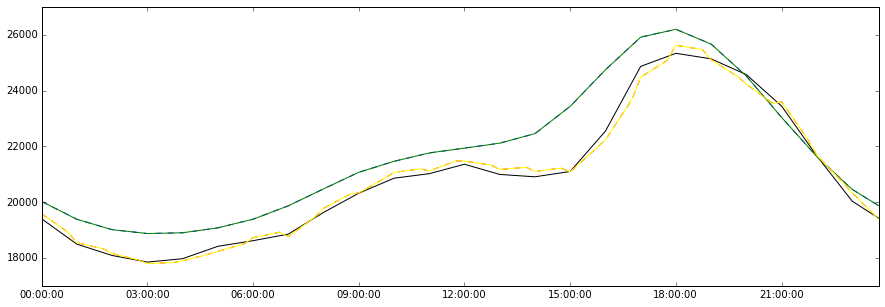

In [23]:
fig = plt.figure(figsize=(5*3, 5*1))
l = range(4200,4500)
#l = range(0,Data5.shape[0])
l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,12,7)].index
l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,11,16)].index
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='green',linestyle='-')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='yellow',linestyle='-')

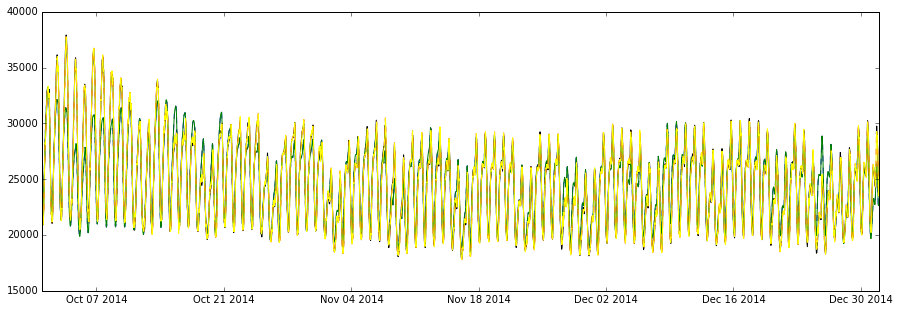

In [24]:
fig = plt.figure(figsize=(5*3, 5*1))
#l = range(4200,4500)
l = range(0,Data5.shape[0])
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')

plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='green',linestyle='-')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='yellow',linestyle='-')

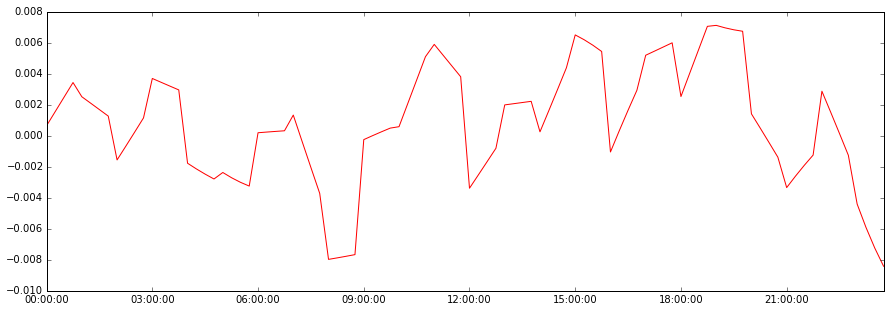

In [25]:
fig = plt.figure(figsize=(5*3, 5*1))
l = range(4000,4500)
l = range(0,Data5.shape[0])
l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,12,7)].index
#l = Data5[Data5.tsLocal.map(lambda x: x.date())==datetime.date(2014,11,18)].index
plt.plot(Data5.loc[l,'tsLocal'],(Data5.loc[l,'netload']-Data5.loc[l,'netload-assign-HourAhead'])/maxload,color='red')

In [26]:
#Closer look at error
d = Data5
d['prediction-difference'] = (d['netload']-d['netload-assign-HourAhead'])/maxload
np.mean(np.absolute(d['prediction-difference'])),np.max(np.absolute(d['prediction-difference']))

(0.0046416062623727663, 0.039677684970442738)

In [27]:
d[(d['prediction-difference']>0.05)|(d['prediction-difference']<-0.05)][['tsLocal','prediction-difference']]

,tsLocal,prediction-difference


In [38]:
#Distribution of volatility 
level = 17
Data1 = DayAheadPredictionAndRamprate(Data)
Data2 = DayAheadMarketAssignment(Data1)
Data3 = HourAheadPredictionAndRamprate(Data2)
Data4 = HourAheadMarketAssignment(Data3)
Data5 = AncillaryServiceCount(Data4)
#Closer look at error
d = Data5
d['prediction-difference'] = (d['netload']-d['netload-assign-HourAhead'])/maxload
#np.mean(np.absolute(d['prediction-difference'])),np.max(np.absolute(d['prediction-difference']))
d[(d['prediction-difference']>0.05)|(d['prediction-difference']<-0.05)][['tsLocal','prediction-difference','V-s']]

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0628688434797 -0.0523630788424 0.00656400269689 0.00101902173913


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,tsLocal,prediction-difference,V-s
627,2014-10-07 12:45:00,0.050725,0.375209
3975,2014-11-11 09:45:00,0.054457,0.004327
3979,2014-11-11 10:45:00,0.054466,0.016976
4663,2014-11-18 13:45:00,0.053705,0.232609
5802,2014-11-30 10:30:00,0.060816,0.095903
5803,2014-11-30 10:45:00,0.062869,0.211974
6188,2014-12-04 11:00:00,0.052847,0.309990
6387,2014-12-06 12:45:00,-0.052363,0.015793
7445,2014-12-17 13:15:00,0.050955,0.235423


In [65]:
#Compile all we need
for level in range(0,32,2):
    print "Level: " + str(level)
    Data1 = DayAheadPredictionAndRamprate(Data)
    Data2 = DayAheadMarketAssignment(Data1)
    Data3 = HourAheadPredictionAndRamprate(Data2)
    Data4 = HourAheadMarketAssignment(Data3)
    Data5 = AncillaryServiceCount(Data4)
    #imbalanceplot()

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Level: 0
0.0396776849704 -0.0367508212836 0.00464160626237 0.0
Level: 2
0.0396776849704 -0.0367508212836 0.00469185338766 0.0
Level: 4
0.0396776849704 -0.0367508212836 0.00483226583894 0.0
Level: 6
0.0396776849704 -0.0367508212836 0.00503296154809 0.0
Level: 8
0.0396776849704 -0.0367508212836 0.00527238497078 0.0
Level: 10
0.0396776849704 -0.0367508212836 0.00553717867672 0.0
Level: 12
0.045739876791 -0.0404459498442 0.00581719015575 0.0
Level: 14
0.0525914634665 -0.0452128014434 0.006109344659 0.000226449275362
Level: 16
0.059443050142 -0.0499796530427 0.0064100442974 0.000566123188406
Level: 18
0.0662946368175 -0.054746504642 0.00671985610652 0.00135869565217
Level: 20
0.073146223493 -0.0595133562413 0.00703491695695 0.00260416666667
Level: 22
0.0799978101685 -0.0642802078406 0.00735403435141 0.00498188405797
Level: 24
0.086849396844 -0.0690470594399 0.00767573434613 0.00792572463768
Level: 26
0.0937009835196 -0.0738139110392 0.00799946218959 0.0105298913043
Level: 28
0.100552570195 

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [91]:
level = range(0,32,2)
risk = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000226449275362, 0.000566123188406, 0.00135869565217, 0.00260416666667
, 0.00498188405797, 0.00792572463768, 0.0105298913043, 0.0137001811594, 0.0169836956522]

dayaheadalert = [ 0, 0, 0, 0, 0, 0, 5, 47, 68, 159, 184, 184, 188, 204, 224, 234]
houraheadalert = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 18, 39, 56]

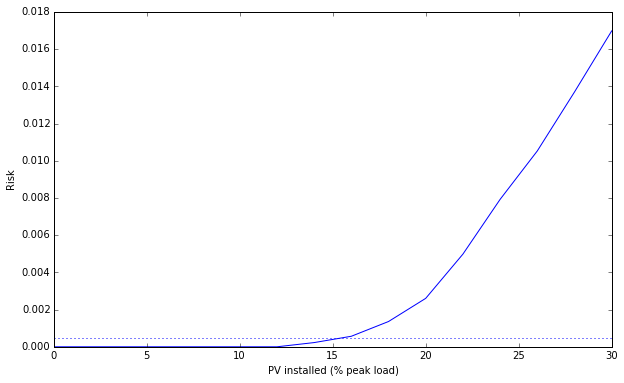

In [92]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
plt.plot(level,risk)
plt.axhline(y=.0005,linestyle=':')
#plt.axvline(x=16,linestyle=':')
plt.xlabel("PV installed (% peak load)")
plt.ylabel("Risk")

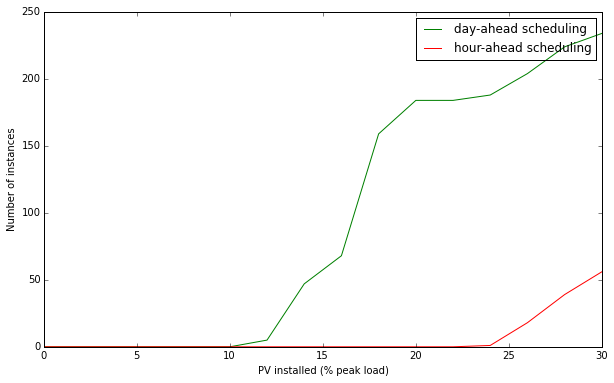

In [94]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
ax1.plot(level,dayaheadalert, color='green', label = 'day-ahead scheduling')
ax1.plot(level,houraheadalert, color='red', label = 'hour-ahead scheduling')
ax1.set_xlabel("PV installed (% peak load)")
ax1.set_ylabel("Number of instances")
ax1.legend()

This suggests that we do not need to modify generators if PV installed is less than 24 % peak load. Consider reducing risk for 16-23% case.

In [2]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [3]:
level = range(16,24)
Risk05 = [ 0.000566123188406, 0.00101902173913, 0.00135869565217, 0.00192481884058, 0.00260416666667, 0.00373641304348,0.00498188405797,0.00634057971014]
Risk06 = [0.0, 0.000226449275362, 0.000226449275362, 0.000339673913043, 0.000679347826087, 0.00101902173913, 0.00147192028986, 0.00203804347826]
Risk07 = [0.0, 0.0, 0.0, 0.0, 0.000226449275362, 0.000226449275362, 0.000339673913043, 0.000679347826087]
Risk08 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000226449275362]
Risk09 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Risk10 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

C:\Users\Tee\Anaconda\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


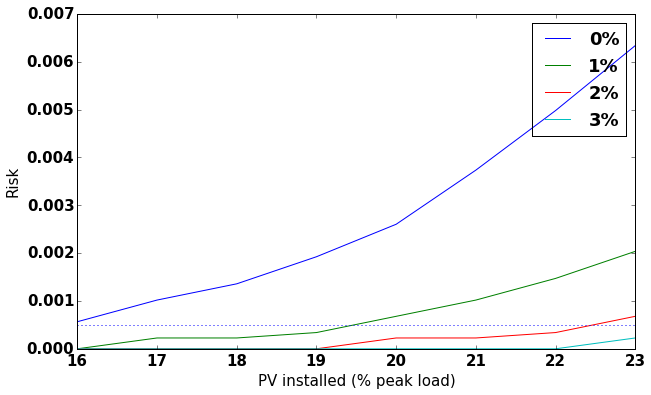

In [4]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
ax1.plot(level,Risk05, label = '0%')
ax1.plot(level,Risk06, label = '1%')
ax1.plot(level,Risk07, label = '2%')
ax1.plot(level,Risk08, label = '3%')
ax1.axhline(y=.0005,linestyle=':')
ax1.set_xlabel("PV installed (% peak load)")
ax1.set_ylabel("Risk")
ax1.legend()

In [82]:
#Consider level from 10 to 15 peak load with different level of ancillary services
AncillaryServiceRatio = 0.05
#Compile all we need
for level in range(16,24):
    print "Level: " + str(level)
    Data1 = DayAheadPredictionAndRamprate(Data)
    Data2 = DayAheadMarketAssignment(Data1)
    Data3 = HourAheadPredictionAndRamprate(Data2)
    Data4 = HourAheadMarketAssignment(Data3)
    Data5 = AncillaryServiceCount(Data4)
    #imbalanceplot()

Level: 16

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0.059443050142 -0.0499796530427 0.0064100442974 0.000566123188406
Level: 17
0.0628688434797 -0.0523630788424 0.00656400269689 0.00101902173913
Level: 18
0.0662946368175 -0.054746504642 0.00671985610652 0.00135869565217
Level: 19
0.0697204301553 -0.0571299304417 0.00687683038139 0.00192481884058
Level: 20
0.073146223493 -0.0595133562413 0.00703491695695 0.00260416666667
Level: 21
0.0765720168308 -0.061896782041 0.00719401173073 0.00373641304348


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
